# 3. Modeling
📒 `3.0-rc-modeling.ipynb`

**Objetivo:** Construir, treinar e otimizar modelos preditivos capazes de identificar falhas nas máquinas e estimar a probabilidade associada a cada classe de defeito.

⚙️ **Atividades:**
- Definição da abordagem de modelagem (binária, multiclasse ou multirrótulo) com base no problema de negócio.
- Seleção dos algoritmos de aprendizado supervisionado (Regressão Logística, Random Forest, Gradient Boosting, SVM, Redes Neurais, entre outros).
- Treinamento inicial dos modelos com os dados processados.
- Ajuste de hiperparâmetros (Grid Search, Random Search, Bayesian Optimization).
- Uso de técnicas de validação (k-fold cross validation, holdout, stratified splits) para garantir robustez.
- Comparação entre diferentes algoritmos e estratégias de modelagem.
- Avaliação do impacto de feature engineering e seleção de variáveis na performance do modelo.
- Aplicação de métodos para lidar com overfitting e underfitting (regularização, ensemble, early stopping).
- Interpretação dos modelos e análise de feature importance/SHAP values.
- Salvamento dos modelos finais em formato serializado (models/).

In [57]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# Pipeline
from sklearn.pipeline import Pipeline
# Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV

# Modelos
from sklearn.linear_model import LogisticRegression # Regressão Logística   
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier # XGBoost

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve


### 1) Carregar artefatos e dados de treino e teste

In [ ]:
# Carrega artefatos da etapa de PREPROCESSING
spec = load("../models/artifacts/preprocessing_spec.joblib")
preprocessor   = spec["preprocessor"]          
RANDOM_SEED    = spec["random_seed"]
target_name    = spec["target_name"]

# Carrega os dados tratados
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")[target_name]
y_test  = pd.read_csv("../data/processed/y_test.csv")[target_name]

# Visualiza o preprocessor
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [48]:
from collections import Counter
print("Distribuição (treino):", Counter(y_train))
print("Proporções (treino):", (y_train.value_counts(normalize=True)*100).round(2).to_dict())

Distribuição (treino): Counter({0: 26176, 1: 412})
Proporções (treino): {0: 98.45, 1: 1.55}


### 2) Treinamento de Modelos

- **Baseline:** LogisticRegression()
- **Ensemble:**  RandomForestClassifier(), XGBClassifier()

Nota:
- Random Forest não precisa de escala, mas manter o preprocessor no pipeline dá consistência se você trocar de modelo (LogReg/SVM/NN) e garante o fluxo único.

#### i) Avaliar Baseline

**Objetivo**: comparar modelos rapidamente sem tuning, mantendo estratificação.

In [64]:
pipe_baseline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)



scores = cross_validate(pipe_baseline, X_train, y_train, cv=cv, scoring=['f1','roc_auc','accuracy'])

print("Scores de validação cruzada: \n", {m: scores[f'test_{m}'].mean() for m in ['f1','roc_auc','accuracy']})

Scores de validação cruzada: 
 {'f1': np.float64(0.09773475458945811), 'roc_auc': np.float64(0.8495603761309651), 'accuracy': np.float64(0.7736949602780554)}


In [65]:
pipe_baseline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Acurácia: 0.7824909747292419
AUC: 0.8719544304924088
F1: 0.1051980198019802
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      6545
           1       0.06      0.83      0.11       103

    accuracy                           0.78      6648
   macro avg       0.53      0.80      0.49      6648
weighted avg       0.98      0.78      0.86      6648

Matriz de Confusão: 
[[5117 1428]
 [  18   85]]


Text(0.5, 0, 'False Positive Rate')

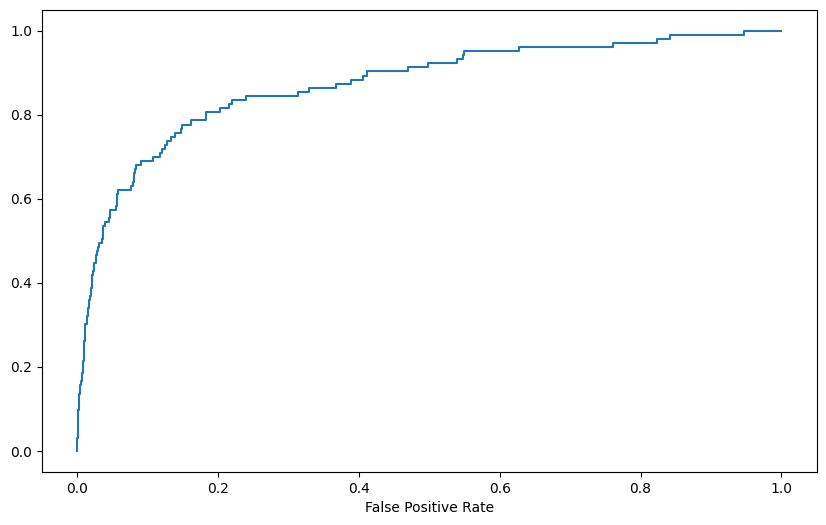

In [66]:
y_pred_baseline = pipe_baseline.predict(X_test)
y_proba_baseline = pipe_baseline.predict_proba(X_test)[:,1]

print(f"Acurácia: {accuracy_score(y_test, y_pred_baseline)}")
print(f"AUC: {roc_auc_score(y_test, y_proba_baseline)}")    
print(f"F1: {f1_score(y_test, y_pred_baseline)}")
print(f"Relatório de Classificação: \n{classification_report(y_test, y_pred_baseline)}")
print(f"Matriz de Confusão: \n{confusion_matrix(y_test, y_pred_baseline)}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')

In [69]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

# Criar o explainer
explainer = ClassifierExplainer(pipe_baseline, X_test, y_test)

# Configurar e executar o dashboard com parâmetros específicos
dashboard = ExplainerDashboard(explainer, 
                             title="Predictive Maintenance Classifier Explainer",
                             whatif=False,  # desativa a aba what-if
                             shap_interaction=False,  # desativa interações SHAP
                             decision_trees=False)  # desativa visualização de árvores

# Executar o dashboard com configurações específicas para Windows
dashboard.run(host='127.0.0.1',  # usar localhost
             port=8050,  
             use_waitress=True)  # usar servidor waitress que é mais estável no Windows

# gere um arquivo html para o dashboard
dashboard.save_html("../reports/classifier_explainer/LogReg_baseline.html")

splitting pipeline...
Detected sklearn/imblearn Pipeline and succesfully extracted final output dataframe with column names and final model...
Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurv

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

c:\Users\reyna\_python_projects\personal\portfolio-projects\predictive-maintenance-failure-classifier\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but LogisticRegression was fitted without feature

#### ii) Avaliar Baseline com Tunning

**Objetivo:** Escolher hiperparâmetros sem vazamento (pré-processamento dentro do pipeline é re-ajustado a cada dobra).

In [34]:
# Cross-Validation (5 folds) para evitar overfitting
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Parâmetros para o Grid Search (l1 lasso l2 ridge) para evitar overfitting
param_grid = {
    'model__C': [0.01, 0.1, 1],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']   # exige entrada densa; veja alternativa abaixo
}


# Grid Search para encontrar os melhores hiperparâmetros
gs = GridSearchCV(
    estimator=pipe_baseline, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True
        ) # troque p/ 'roc_auc', 'f1_macro', etc. conforme sua métrica-alvo

gs.fit(X_train, y_train)

print("Melhores hiperparâmetros:", gs.best_params_)
print("Score CV (média):", gs.best_score_)

best_pipe = gs.best_estimator_

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
print(f"Relatório de Classificação: \n{classification_report(y_test, y_pred)}")
print(f"Matriz de Confusão: \n{confusion_matrix(y_test, y_pred)}")

Melhores hiperparâmetros: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Score CV (média): 0.7738829726020896
Acurácia: 0.782942238267148
Relatório de Classificação: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      6545
           1       0.06      0.83      0.11       103

    accuracy                           0.78      6648
   macro avg       0.53      0.80      0.49      6648
weighted avg       0.98      0.78      0.86      6648

Matriz de Confusão: 
[[5120 1425]
 [  18   85]]


#### iii) Emseble Models

##### RandomForestClassifier()

In [42]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


# Pipeline
pipe_rf = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced', n_jobs=-1))
])

rf_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 8, 12, 16],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", None],
}

rf_search = RandomizedSearchCV(
    pipe_rf, rf_param_grid, n_iter=12, cv=cv, scoring="accuracy",
    n_jobs=-1, random_state=RANDOM_SEED, refit=True
)

rf_search.fit(X_train, y_train)

print("RF best f1 (CV):", rf_search.best_score_, rf_search.best_params_)

RF best f1 (CV): 0.9859334796680951 {'model__n_estimators': 100, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': None}


##### XGBoost ()

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# === Lidar com desbalanceamento para XGB ===
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

# Pipeline XGBoost
pipe_xgb = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    ))
])

# Parâmetros para o Grid Search
xgb_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__subsample": [0.7, 1.0],
    "model__colsample_bytree": [0.7, 1.0],
}

#RandomizedSearch
xgb_search = RandomizedSearchCV(
    pipe_xgb, xgb_dist, n_iter=12, cv=cv, scoring="accuracy",
    n_jobs=-1, random_state=RANDOM_SEED, refit=True
)

# Fit RandomizedSearch
xgb_search.fit(X_train, y_train)

print("XGB best f1 (CV):", xgb_search.best_score_, xgb_search.best_params_)

XGB best f1 (CV): 0.982661353765625 {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.7}


In [47]:
# === Escolher o melhor entre RF e XGB pela métrica de CV
if xgb_search.best_score_ > rf_search.best_score_:
    best_name = "xgboost"
    best_pipe = xgb_search.best_estimator_
else:
    best_name = "random_forest"
    best_pipe = rf_search.best_estimator_

print(f"\n>> Melhor modelo (CV): {best_name}")

# === Avaliar no holdout
y_pred  = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("\nHoldout:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


>> Melhor modelo (CV): random_forest

Holdout:
Accuracy : 0.9869133574007221
F1-score : 0.445859872611465

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6545
           1       0.65      0.34      0.45       103

    accuracy                           0.99      6648
   macro avg       0.82      0.67      0.72      6648
weighted avg       0.98      0.99      0.98      6648

Confusion Matrix:
 [[6526   19]
 [  68   35]]


In [35]:
# Logistic Regression as a baseline, Random Forest and XGBoost as ensemble methods

ensemble_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

pipe = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_SEED
    ))
])


# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Scores
scores = cross_validate(
    pipe, X_train, y_train, cv=cv,
    scoring=["f1","roc_auc","accuracy"],
    return_train_score=False, n_jobs=-1
)
print("Scores de validação cruzada: \n", {k: scores[k].mean() for k in scores if k.startswith("test_")})

# Aplica o pipeline nos dados de treino
pipe.fit(X_train, y_train)

# Predição
y_pred = pipe.predict(X_test)

# Predição em probabilidades
y_proba = pipe.predict_proba(X_test)[:,1]

Scores de validação cruzada: 
 {'test_f1': np.float64(0.3105586385497595), 'test_roc_auc': np.float64(0.900402371046583), 'test_accuracy': np.float64(0.9862343941672254)}


In [ ]:
import os, joblib, numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

DATA_INTERIM = "../data/interim"
DATA_PROCESSED = "../data/processed"
os.makedirs(DATA_PROCESSED, exist_ok=True)

X_train = pd.read_csv(os.path.join(DATA_INTERIM,"X_train.csv"))
X_valid = pd.read_csv(os.path.join(DATA_INTERIM,"X_valid.csv"))
y_train = pd.read_csv(os.path.join(DATA_INTERIM,"y_train.csv"))
y_valid = pd.read_csv(os.path.join(DATA_INTERIM,"y_valid.csv"))
target_cols = ["falha_maquina","FDF","FDC","FP","FTE","FA"]
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])

baseline = Pipeline([("prep", preprocess), ("clf", OneVsRestClassifier(LogisticRegression(max_iter=200)))])
baseline.fit(X_train, y_train[target_cols])
y_pred = (baseline.predict_proba(X_valid) >= 0.5).astype(int)
print(classification_report(y_valid[target_cols], y_pred, target_names=target_cols, zero_division=0))
joblib.dump(baseline, os.path.join(DATA_PROCESSED,"model_baseline.joblib"))